# Notebook to construct different noise injection modes

In [1]:
import os, sys
from pathlib import Path
print(os.getcwd())
print(os.getcwd())

parent_dir = Path.cwd().parent.resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

%load_ext autoreload
%autoreload 2

/mnt/dlabscratch1/anmari/dit-editor/notebooks
/mnt/dlabscratch1/anmari/dit-editor/notebooks


In [2]:
import numpy as np
import torch
from PIL import Image


import gc
from accelerate.utils import release_memory

from data.benchmark_data import gather_images
from cache_and_edit.inversion import place_image_in_bounding_box, get_inverted_input_noise, resize_bounding_box, compose_noise_masks



from importlib import reload
import cache_and_edit
reload(cache_and_edit)
from cache_and_edit import *
import cache_and_edit.hooks
reload(cache_and_edit.hooks)


os.environ['HF_HOME'] = '/dlabscratch1/anmari'
os.environ['TRANSFORMERS_CACHE'] = '/dlabscratch1/anmari'
os.environ['HF_DATASETS_CACHE'] = '/dlabscratch1/anmari'


## Load Model

In [3]:
def clear_all_gpu_memory():
    # Run garbage collection
    gc.collect()

    # Get number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Found {num_gpus} GPU(s).")

    # Iterate through each GPU
    for device_id in range(num_gpus):
        with torch.cuda.device(device_id):
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.reset_accumulated_memory_stats()
            release_memory()
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.ipc_collect()
    print("GPU memory cleared across all available devices.")

clear_all_gpu_memory()

Found 1 GPU(s).
GPU memory cleared across all available devices.


In [4]:
from cache_and_edit.flux_pipeline import EditedFluxPipeline

dtype = torch.float16
pipe = EditedFluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", 
                                    device_map="balanced",
                                    torch_dtype=dtype)
pipe.set_progress_bar_config(disable=True)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [5]:
cached_pipe = CachedPipeline(pipe)

## Load images

In [46]:
os_path = "../benchmark_images_generations/"
all_images = gather_images(os_path)

example = all_images[0]
print(example.category)
print(example.prompt)

Missing images in ../benchmark_images_generations/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style: fg_mask
Skipping ../benchmark_images_generations/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style: Not all images are present in ../benchmark_images_generations/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style
Missing images in ../benchmark_images_generations/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic: fg_mask
Skipping ../benchmark_images_generations/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic: Not all images are present in ../benchmark_images_generations/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic
Loaded 330 images in ../benchmark_images_generations/
Real-Cartoon
a cartoon animation of a sheep in the forest


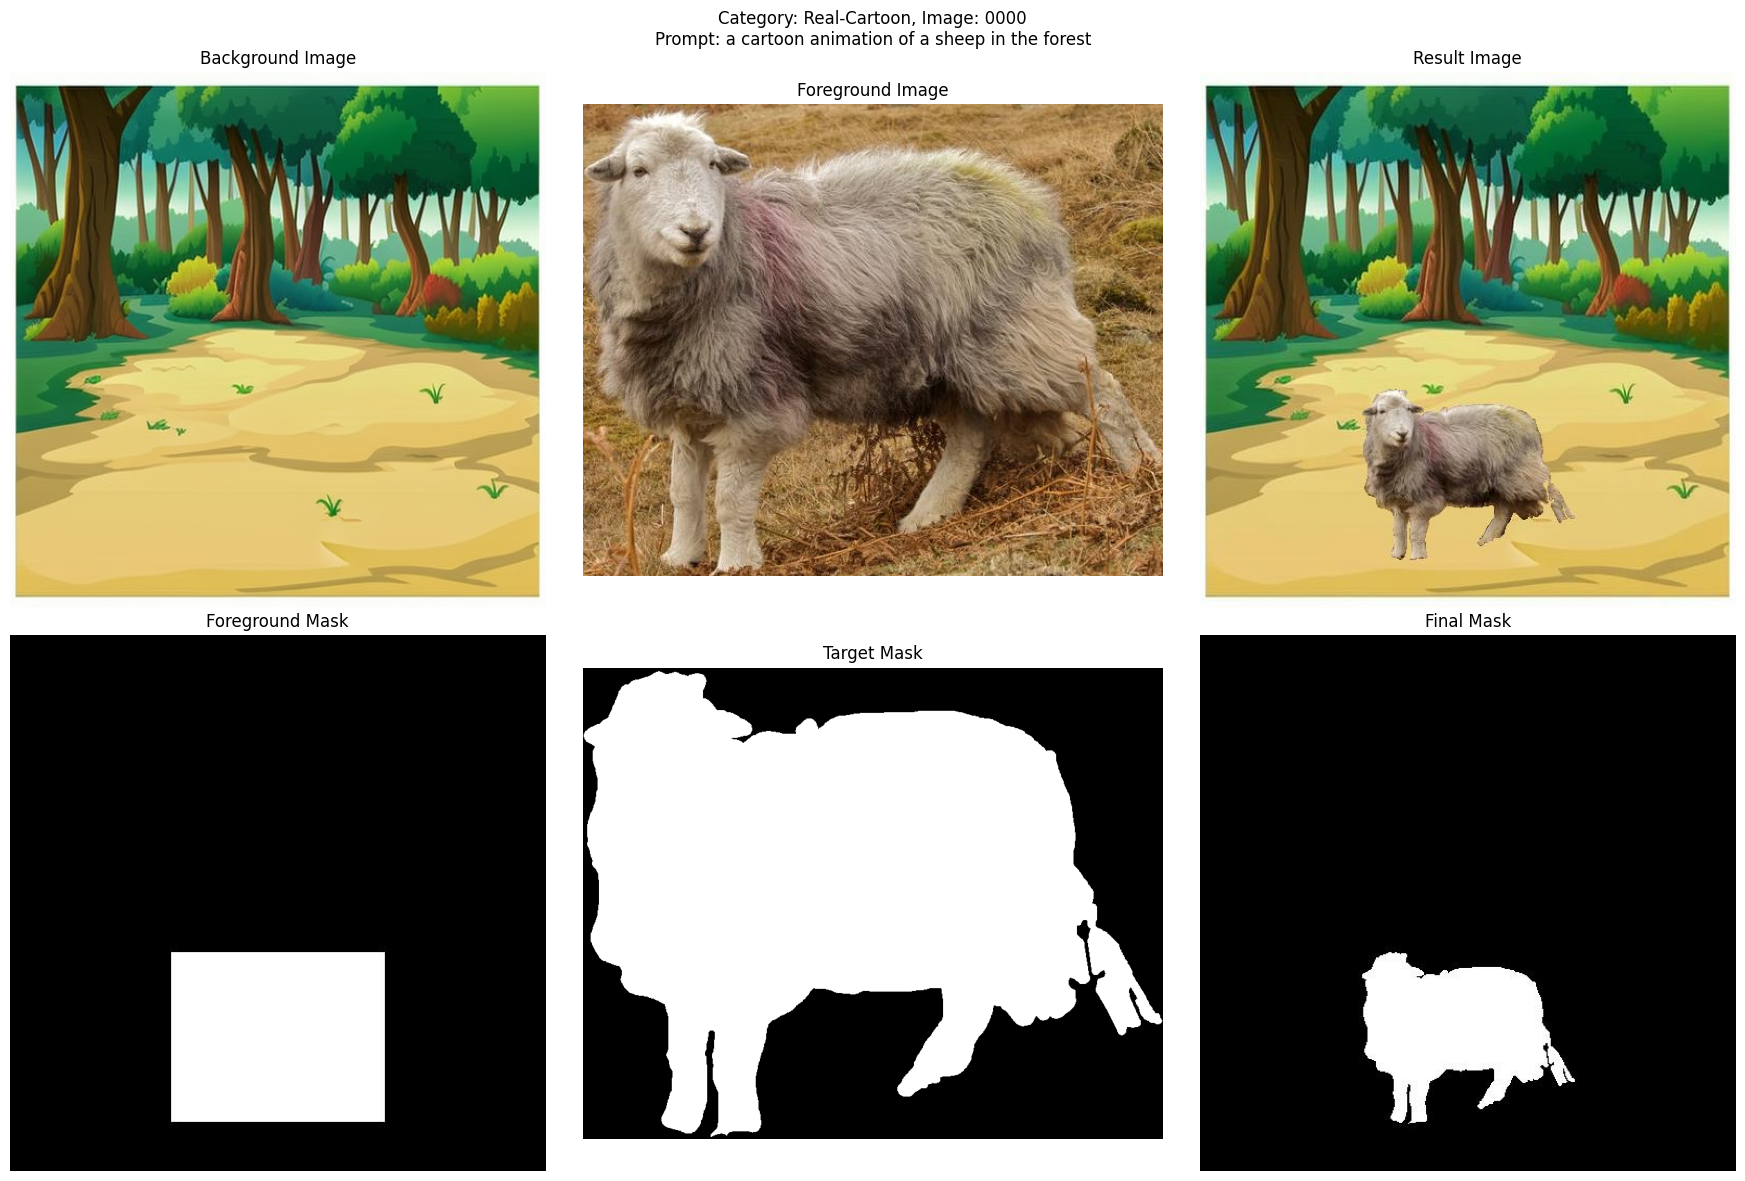

In [47]:
example.plot_sample()

In [8]:
from cache_and_edit.inversion import compose_noise_masks

Segmented and Palced FG Image


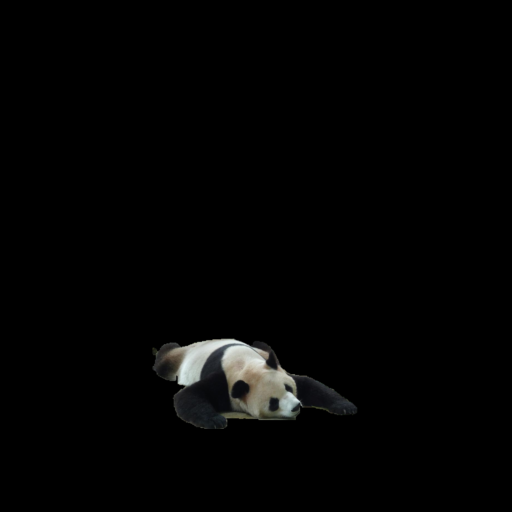

Placed Segmentation Mask


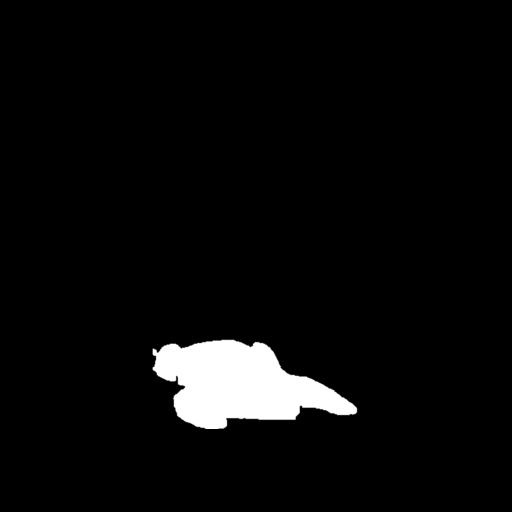

Photoshopping FG IMAGE


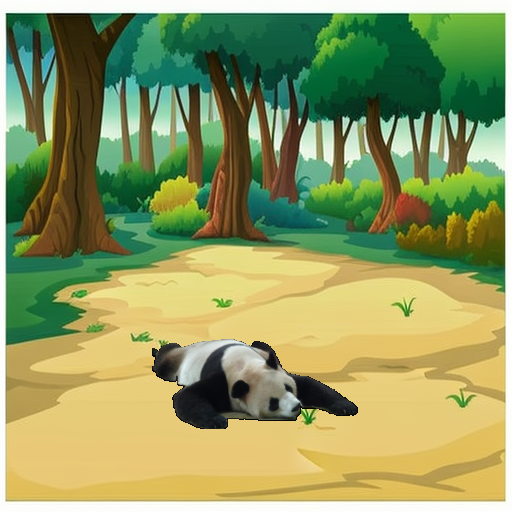

In [42]:
example = all_images[1]

example_noise = compose_noise_masks(cached_pipe, 
              example.fg_image, 
              example.bg_image, 
              example.target_mask, 
              example.fg_mask, 
              option="segmentation1", 
              num_inversion_steps=28,
              photoshop_fg_noise=True,)

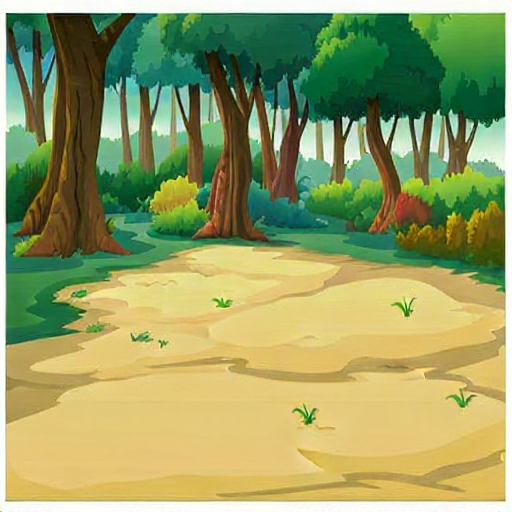

In [9]:
images = cached_pipe.run(
    ["A sheep in the forest"],
    num_inference_steps=28,
    seed=42,
    guidance_scale=8.5,
    empty_clip_embeddings=False,
    latents=example_noise["noise"]["background_noise"].unsqueeze(0),              
    width=512,
    height=512,
    inverted_latents_list = example_noise["noise"]["background_noise_list"],
)
display(images[0][0])

Available Masks:
latent_segmentation_mask
Available Noises:
composed_noise
foreground_noise
background_noise
foreground_noise_list
background_noise_list
<class 'cache_and_edit.flux_pipeline.EditedFluxPipeline'>
transformer.transformer_blocks.0 True
transformer.transformer_blocks.1 True
transformer.transformer_blocks.2 True
transformer.transformer_blocks.3 True
transformer.transformer_blocks.4 True
transformer.transformer_blocks.5 True
transformer.transformer_blocks.6 True
transformer.transformer_blocks.7 True
transformer.transformer_blocks.8 True
transformer.transformer_blocks.9 True
transformer.transformer_blocks.10 True
transformer.transformer_blocks.11 True
transformer.transformer_blocks.12 True
transformer.transformer_blocks.13 True
transformer.transformer_blocks.14 True
transformer.transformer_blocks.15 True
transformer.transformer_blocks.16 True
transformer.transformer_blocks.17 True
transformer.transformer_blocks.18 True
transformer.single_transformer_blocks.0 True
transformer.s

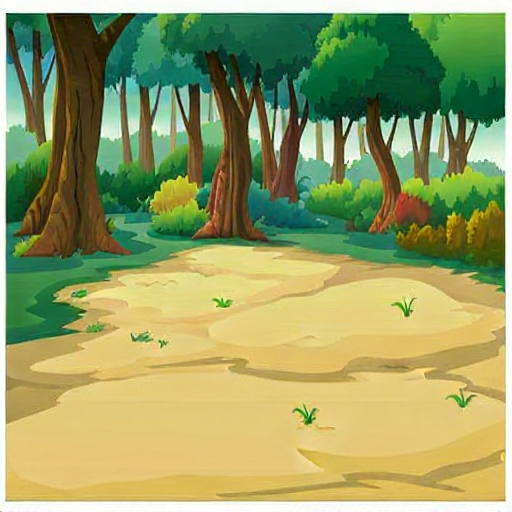

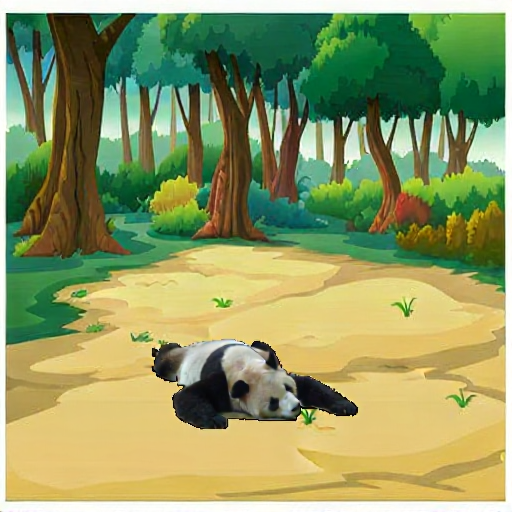

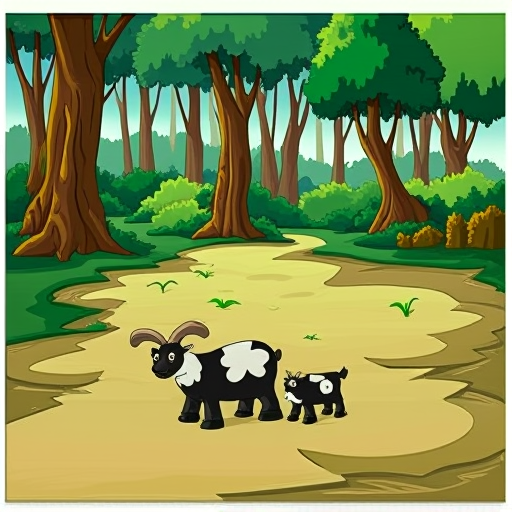

In [45]:
from functools import partial
from cache_and_edit.qkv_cache import TFICONAttnProcessor

print("Available Masks:")
for key in example_noise["latent_masks"].keys():
    print(key)
print("Available Noises:")
for key in example_noise["noise"].keys():
    print(key)


vital_layers = [f"transformer.transformer_blocks.{i}" for i in [0, 1, 17, 18]] + \
                [f"transformer.single_transformer_blocks.{i-19}" for i in [25, 28, 53, 54, 56]]

all_layers = [f"transformer.transformer_blocks.{i}" for i in range(19)] + \
                [f"transformer.single_transformer_blocks.{i-19}" for i in range(19, 57)]

images = cached_pipe.run_inject_qkv(
    ["A cartoon forest", "A goat", "A green goat in a cartoon forest"],
    num_inference_steps=28,
    seed=42,
    guidance_scale=3,
    positions_to_inject=all_layers,
    positions_to_inject_foreground=all_layers,
    empty_clip_embeddings=False,
    q_mask=example_noise["latent_masks"]["latent_segmentation_mask"],
    latents=torch.stack(
                        [
                        example_noise["noise"]["background_noise"],
                        example_noise["noise"]["foreground_noise"],
                        torch.where(
                            example_noise["latent_masks"]["latent_segmentation_mask"] > 0,
                            example_noise["noise"]["foreground_noise"],
                            example_noise["noise"]["background_noise"],
                        ),
                        ]
                    ),
    # latents=torch.stack([bg_noise, fg_noise, tficon_noise]),
    processor_class=partial(TFICONAttnProcessor, call_max_times=10),
    width=512,
    height=512,
    inverted_latents_list = list(zip(example_noise["noise"]["background_noise_list"], example_noise["noise"]["foreground_noise_list"]))
)

display(images[0][0])
display(images[0][1])
display(images[0][2])

Available Masks:
latent_segmentation_mask
Available Noises:
composed_noise
foreground_noise
background_noise
foreground_noise_list
background_noise_list
<class 'cache_and_edit.flux_pipeline.EditedFluxPipeline'>
transformer.transformer_blocks.0 True
transformer.transformer_blocks.1 True
transformer.transformer_blocks.2 False
transformer.transformer_blocks.3 False
transformer.transformer_blocks.4 False
transformer.transformer_blocks.5 False
transformer.transformer_blocks.6 False
transformer.transformer_blocks.7 False
transformer.transformer_blocks.8 False
transformer.transformer_blocks.9 False
transformer.transformer_blocks.10 False
transformer.transformer_blocks.11 False
transformer.transformer_blocks.12 False
transformer.transformer_blocks.13 False
transformer.transformer_blocks.14 False
transformer.transformer_blocks.15 False
transformer.transformer_blocks.16 False
transformer.transformer_blocks.17 True
transformer.transformer_blocks.18 True
transformer.single_transformer_blocks.0 Fal

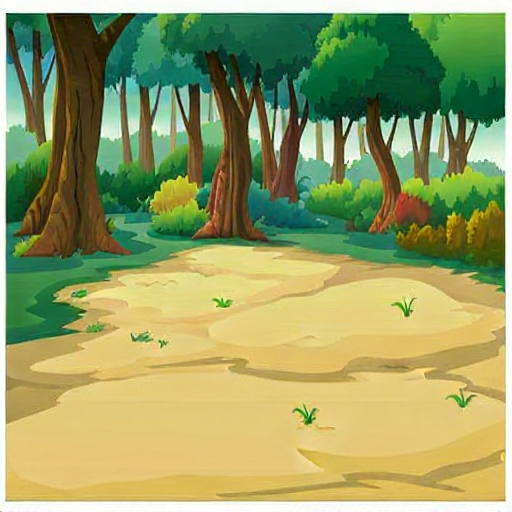

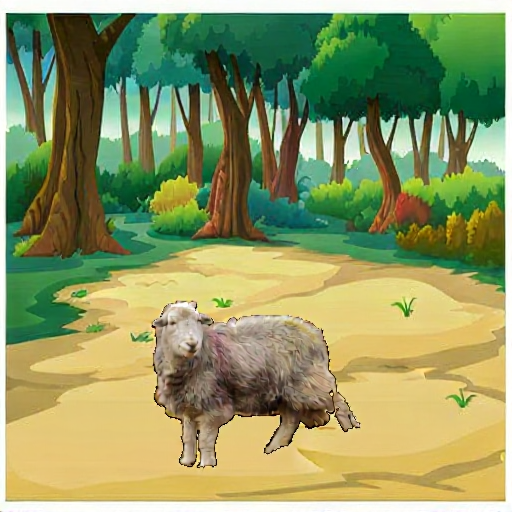

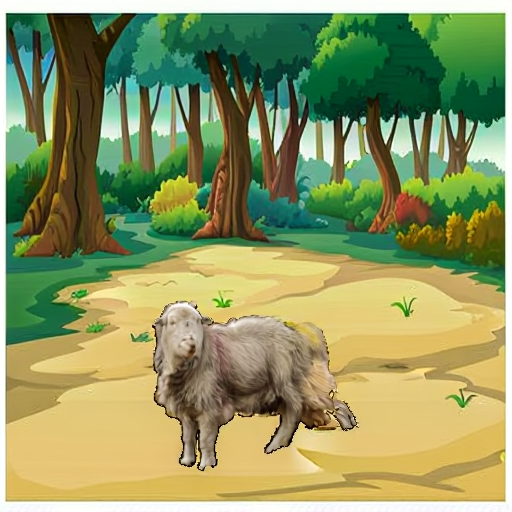

In [25]:
# STableFlow


from cache_and_edit.qkv_cache import TFICONAttnProcessor

print("Available Masks:")
for key in example_noise["latent_masks"].keys():
    print(key)
print("Available Noises:")
for key in example_noise["noise"].keys():
    print(key)


vital_layers = [f"transformer.transformer_blocks.{i}" for i in [0, 1, 17, 18]] + \
                [f"transformer.single_transformer_blocks.{i-19}" for i in [25, 28, 53, 54, 56]]

all_layers = [f"transformer.transformer_blocks.{i}" for i in range(19)] + \
                [f"transformer.single_transformer_blocks.{i-19}" for i in range(19, 57)]

images = cached_pipe.run_inject_qkv(
    ["", "", ""],
    num_inference_steps=28,
    seed=42,
    guidance_scale=0,
    positions_to_inject=all_layers,
    positions_to_inject_foreground=vital_layers,
    empty_clip_embeddings=False,
    q_mask=example_noise["latent_masks"]["latent_segmentation_mask"],
    latents=torch.stack(
                        [
                        example_noise["noise"]["background_noise"],
                        example_noise["noise"]["foreground_noise"],
                        torch.where(
                            example_noise["latent_masks"]["latent_segmentation_mask"] > 0,
                            example_noise["noise"]["foreground_noise"],
                            example_noise["noise"]["background_noise"],
                        ),
                        ]
                    ),
    inverted_latents_list = list(zip(example_noise["noise"]["background_noise_list"], example_noise["noise"]["foreground_noise_list"])),
    width=512,
    height=512,
)

display(images[0][0])
display(images[0][1])
display(images[0][2])

In [ ]:
image = pipe.image_processor.preprocess(image).type(self.pipe.vae.dtype).to("cuda")
latents = self.pipe.vae.encode(image)["latent_dist"].mean

Available Masks:
latent_segmentation_mask
Available Noises:
composed_noise
foreground_noise
background_noise
foreground_noise_list
background_noise_list


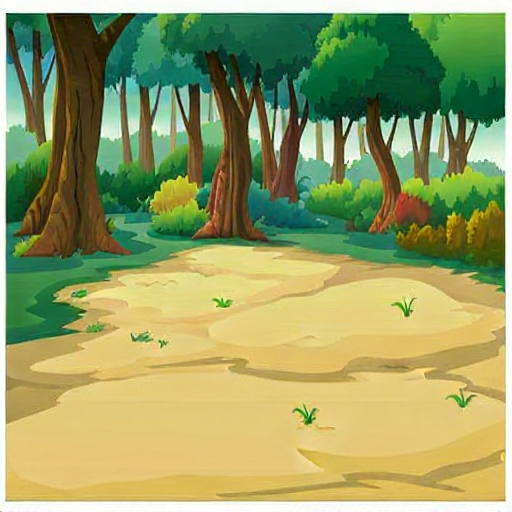

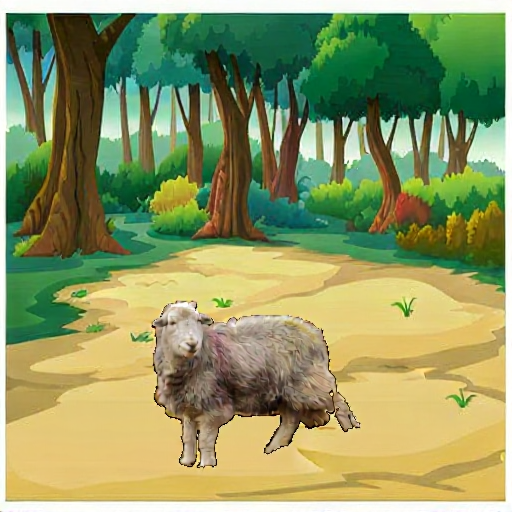

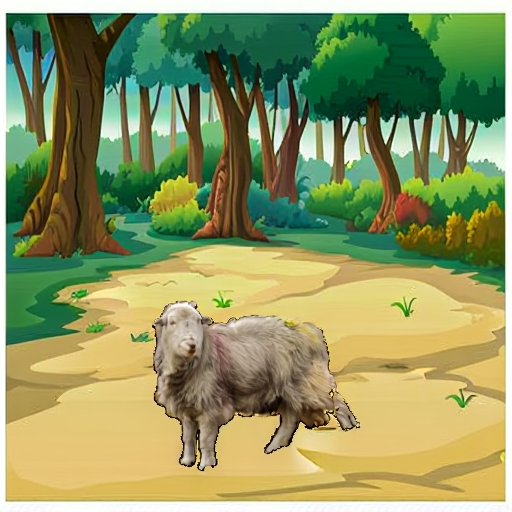

In [30]:
# Activation PAtching


from cache_and_edit.qkv_cache import TFICONAttnProcessor

print("Available Masks:")
for key in example_noise["latent_masks"].keys():
    print(key)
print("Available Noises:")
for key in example_noise["noise"].keys():
    print(key)


vital_layers = [f"transformer.transformer_blocks.{i}" for i in [0, 1, 17, 18]] + \
                [f"transformer.single_transformer_blocks.{i-19}" for i in [25, 28, 53, 54, 56]]

all_layers = [f"transformer.transformer_blocks.{i}" for i in range(19)] + \
                [f"transformer.single_transformer_blocks.{i-19}" for i in range(19, 57)]

from functools import partial

@torch.no_grad
def patch_foreground_activations_flat(input: torch.Tensor, 
                output: torch.Tensor,
                layer: int,
                weight_foreground: float = 0.2,
                mask: torch.Tensor = None,
                ):

    output[2:][mask] = (output[2:][mask] * (1 - weight_foreground) + output[1:2][mask] * weight_foreground)

    return output

images = cached_pipe.run_with_edit(
    ["", "", ""],
    num_inference_steps=28,
    seed=42,
    guidance_scale=0,
    empty_clip_embeddings=False,
    edit_fn=partial(patch_foreground_activations_flat, mask=example_noise["latent_masks"]["latent_segmentation_mask"].to(dtype=bool).transpose(0, 1)),
    layers_for_edit_fn=[i for i in range(18, 19)],
    stream="image",
    latents=torch.stack(
                    [
                    example_noise["noise"]["background_noise"],
                    example_noise["noise"]["foreground_noise"],
                    torch.where(
                        example_noise["latent_masks"]["latent_segmentation_mask"] > 0,
                        example_noise["noise"]["foreground_noise"],
                        example_noise["noise"]["background_noise"],
                    ),
                    ]
                ),
    inverted_latents_list = list(zip(example_noise["noise"]["background_noise_list"], example_noise["noise"]["foreground_noise_list"])),
    width=512,
    height=512,
).images


display(images[0])
display(images[1])
display(images[2])

## DUMP

In [14]:
### Function to cut image and put it in bounding box (either cut or not cut)
def compose_noise_masks(cached_pipe,
                  foreground_image: Image, 
                  background_image: Image, 
                  target_mask: torch.Tensor,
                  foreground_mask: torch.Tensor,
                  option: str = "bg", # bg, bg_fg, segmentation1, tf_icon
                  photoshop_fg_noise: bool = False,
                  num_inversion_steps: int = 100,
                  ):
    
    # assert options
    assert option in ["bg", "bg_fg", "segmentation1", "segmentation2"], f"Invalid option: {option}"
    
    # calculate size of latent noise for mask resizing
    PATCH_SIZE = 16
    latent_size = background_image.size[0] // PATCH_SIZE
    latents = (latent_size, latent_size)

    # process the options
    if option == "bg":
        # only background noise
        bg_noise = get_inverted_input_noise(cached_pipe, background_image, num_steps=num_inversion_steps)
        composed_noise = bg_noise

        all_noise = {
                "composed_noise": composed_noise,
                "background_noise": bg_noise,
                }
        all_latent_masks = {}


    elif option == "bg_fg":

        # resize and scale the image to the bounding box
        reframed_fg_img, resized_mask = place_image_in_bounding_box(
        torch.from_numpy(np.array(foreground_image)),
        (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        print("Placed Foreground Image")
        reframed_fg_img = Image.fromarray(reframed_fg_img.numpy())
        display(reframed_fg_img)

        print("Placed Mask")
        resized_mask_img = Image.fromarray((resized_mask.numpy() * 255).astype(np.uint8))
        display(resized_mask_img)

        # invert resized & padded image
        if photoshop_fg_noise:
            print("Photoshopping FG IMAGE")
            photoshop_img = Image.fromarray(
                (torch.tensor(np.array(background_image)) * ~resized_mask.cpu().unsqueeze(-1) + torch.tensor(np.array(reframed_fg_img)) * resized_mask.cpu().unsqueeze(-1)).numpy()
            )
            display(photoshop_img)
            fg_noise = get_inverted_input_noise(cached_pipe, photoshop_img, num_steps=num_inversion_steps)
        else:
            fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)
        bg_noise = get_inverted_input_noise(cached_pipe, background_image, num_steps=num_inversion_steps)

        # overwrite get masked in latent space
        latent_mask = resize_bounding_box(
            resized_mask,
            target_size=latents,
                ).flatten().unsqueeze(-1).to("cuda")

        # compose the noise
        composed_noise = bg_noise * (~latent_mask) + fg_noise * latent_mask
        all_latent_masks = {
            "latent_mask": latent_mask,
                }
        all_noise = {
                "composed_noise": composed_noise,
                "foreground_noise": fg_noise,
                "background_noise": bg_noise,
                    }
        
    elif option == "segmentation1":
        # cut out the object and compose it with the background noise
        
        # segmented foreground image
        segmented_fg_image = torch.tensor(
        np.array(
        foreground_mask.resize(foreground_image.size)
        )).to(torch.bool).unsqueeze(-1) * torch.tensor(
            np.array(foreground_image)
            )
        
        # resize and scale the image to the bounding box
        reframed_fg_img, resized_mask = place_image_in_bounding_box(
        segmented_fg_image,
        (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        print("Segmented and Palced FG Image")
        reframed_fg_img = Image.fromarray(reframed_fg_img.numpy())
        display(reframed_fg_img)

        resized_mask_img = Image.fromarray((resized_mask.numpy() * 255).astype(np.uint8))

        # resize and scale the mask itself
        foreground_mask = foreground_mask.convert("RGB") # to avoid extraction of contours and make work with function
        reframed_segmentation_mask, resized_mask = place_image_in_bounding_box(
            torch.from_numpy(np.array(foreground_mask)),
            (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        reframed_segmentation_mask = reframed_segmentation_mask.numpy()
        reframed_segmentation_mask_img = Image.fromarray(reframed_segmentation_mask)
        print("Placed Segmentation Mask")
        display(reframed_segmentation_mask_img)

        # invert resized & padded image 
        # fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)

        if photoshop_fg_noise:
            # temporarily convert to apply mask
            print("Photoshopping FG IMAGE")
            seg_mask_temp = torch.from_numpy(reframed_segmentation_mask).bool()
            bg_temp = torch.tensor(np.array(background_image))
            fg_temp = torch.tensor(np.array(reframed_fg_img))

            photoshop_img = Image.fromarray(
                (bg_temp * (~seg_mask_temp) + fg_temp * seg_mask_temp).numpy()
            ).convert("RGB")
            display(photoshop_img)
            fg_noise = get_inverted_input_noise(cached_pipe, photoshop_img, num_steps=num_inversion_steps)
        else:
            fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)


        bg_noise = get_inverted_input_noise(cached_pipe, background_image, num_steps=num_inversion_steps)

        # overwrite background in resized mask
        # convert mask from 512x512x3 to 512x512 first
        reframed_segmentation_mask = reframed_segmentation_mask[:, :, 0]
        reframed_segmentation_mask = torch.from_numpy(reframed_segmentation_mask).to(dtype=bool)
        latent_mask = resize_bounding_box(
            reframed_segmentation_mask,
            target_size=latents,
        ).flatten().unsqueeze(-1).to("cuda")

        # compose noise
        composed_noise = bg_noise * (~latent_mask) + fg_noise * latent_mask

        all_latent_masks = {
            "latent_segmentation_mask": latent_mask,
            }
        all_noise = {
                "composed_noise": composed_noise,
                "foreground_noise": fg_noise,
                "background_noise": bg_noise,
                    }

        
    elif option == "segmentation2":
        # add random noise in the background

        # segmented foreground image
        segmented_fg_image = torch.tensor(
        np.array(
        foreground_mask.resize(foreground_image.size)
        )).to(torch.bool).unsqueeze(-1) * torch.tensor(
            np.array(foreground_image)
            )
        
        # resize and scale the image to the bounding box
        reframed_fg_img, resized_mask = place_image_in_bounding_box(
        segmented_fg_image,
        (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        print("Segmented and Placed FG Image")
        reframed_fg_img = Image.fromarray(reframed_fg_img.numpy())
        display(reframed_fg_img)

        # resize and scale the mask itself
        foreground_mask = foreground_mask.convert("RGB")
        reframed_segmentation_mask, resized_mask = place_image_in_bounding_box(
            torch.from_numpy(np.array(foreground_mask)),
            (torch.from_numpy(np.array(target_mask)) / 255.0).to(dtype=bool)
        )

        reframed_segmentation_mask = reframed_segmentation_mask.numpy()
        reframed_segmentation_mask_img = Image.fromarray(reframed_segmentation_mask)
        print("Reframed Segmentation Mask")
        display(reframed_segmentation_mask_img)

        xor_mask = target_mask ^ np.array(reframed_segmentation_mask_img.convert("L"))
        print("XOR Mask")
        display(Image.fromarray(xor_mask))

        # invert resized & padded image 
        # fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)
        if photoshop_fg_noise:
            print("Photoshopping FG IMAGE")
            # temporarily convert to apply mask
            seg_mask_temp = torch.from_numpy(reframed_segmentation_mask).bool()
            bg_temp = torch.tensor(np.array(background_image))
            fg_temp = torch.tensor(np.array(reframed_fg_img))

            photoshop_img = Image.fromarray(
                (bg_temp * (~seg_mask_temp) + fg_temp * seg_mask_temp).numpy()
            ).convert("RGB")
            display(photoshop_img)
            fg_noise = get_inverted_input_noise(cached_pipe, photoshop_img, num_steps=num_inversion_steps)
        else:
            fg_noise = get_inverted_input_noise(cached_pipe, reframed_fg_img, num_steps=num_inversion_steps)
        bg_noise = get_inverted_input_noise(cached_pipe, background_image, num_steps=num_inversion_steps)

        # overwrite background in resized mask
        # convert mask from 512x512x3 to 512x512
        reframed_segmentation_mask = reframed_segmentation_mask[:, :, 0]
        reframed_segmentation_mask = torch.from_numpy(reframed_segmentation_mask).to(dtype=bool)

        # get all masks in latents and move to device
        latent_seg_mask = resize_bounding_box(
            reframed_segmentation_mask,
            target_size=latents,
        ).flatten().unsqueeze(-1).to("cuda")
        print(latent_seg_mask.shape)


        latent_xor_mask = resize_bounding_box(
            torch.from_numpy(xor_mask),
            target_size=latents,
        ).flatten().unsqueeze(-1).to("cuda")


        print(resized_mask.shape)
        latent_target_mask = resize_bounding_box(
            resized_mask,
            target_size=latents,
        ).flatten().unsqueeze(-1).to("cuda")

        # implement x∗T = xrT ⊙Mseg +xmT ⊙(1−Muser)+z⊙(Muser ⊕Mseg)
        bg = bg_noise * (~latent_target_mask)
        fg = fg_noise * latent_seg_mask
        boundary = latent_xor_mask * torch.randn(latent_xor_mask.shape).to("cuda")
        composed_noise = bg + fg + boundary

        all_latent_masks = {
            "latent_target_mask": latent_target_mask,
            "latent_segmentation_mask": latent_seg_mask,
            "latent_xor_mask": latent_xor_mask,
                            }
        all_noise = {
                "composed_noise": composed_noise,
                "foreground_noise": fg_noise,
                "background_noise": bg_noise,
                    }
    # output 
    return {
        "noise": all_noise,
        "latent_masks": all_latent_masks,
            }
